<a href="https://colab.research.google.com/github/lilyzhizhou/ML-Final-Project/blob/main/Final_assn_Neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries

In [1]:
# importing PyTorch library as 't' for convenience
import torch as t

# importing other necessary libraries
import numpy as np
from torch.nn.functional import sigmoid, relu, tanh
from torch.optim import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.impute import SimpleImputer

!pip install category_encoders
from category_encoders import OneHotEncoder, TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
# importing PyTorch modules for building neural networks
from torch.nn import Tanh, Linear, Sequential, Sigmoid, Dropout

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 1.8 MB/s eta 0:00:00


Load data

In [2]:
# Read CSV file into Pandas df
import pandas as pd

df = pd.read_csv('datapd.csv')
df.head()

,Unnamed: 0,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex,Patient_ID
0,2,1,63,30.9,NaN,0,1,0,1,0,1,1,1001000000000054
1,2386,1,66,23.6,3.54,1,1,1,0,0,1,1,1001000000004538
2,7781,0,68,34.3,5.55,1,1,1,0,0,1,0,1001000000007331
3,7644,1,73,28.5,3.78,1,1,0,1,1,1,0,1001000000007333
4,2290,0,53,33.4,5.38,0,1,1,0,1,1,0,1001000000009032


Checking Data Types

In [3]:
# checking the data types
df.dtypes

Unnamed: 0             int64
predm                  int64
Age_at_Exam            int64
BMI                  float64
Total_Cholesterol    float64
Depression             int64
HTN                    int64
OA                     int64
COPD                   int64
corstrd_bin            int64
htnmed_bin             int64
Sex                    int64
Patient_ID             int64
dtype: object

In [4]:
#remove "Patient_ID" column
df=df.drop('Patient_ID', axis=1)

Define numerical and categorical columns

In [5]:
# create list of numerical, categorical, multinomial features
target_column = 'predm'
categorical_columns = ['Depression', 'HTN',
                       'OA', 'COPD', 'Sex',
                       'corstrd_bin','htnmed_bin']
#multinomial_columns = [] there are none
numerical_columns = ['Age_at_Exam','BMI','Total_Cholesterol']

Convert numeric categorical categories into descriptive categories

In [6]:
# Convert numeric categorical variables into descriptive categories
df_descr = df.copy()

df_descr['predm'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['Depression'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['HTN'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['OA'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['COPD'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['corstrd_bin'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)
df_descr['htnmed_bin'].replace({0 : 'No', 1 : 'Yes'}, inplace=True)

df_descr.head()

,Unnamed: 0,predm,Age_at_Exam,BMI,Total_Cholesterol,Depression,HTN,OA,COPD,corstrd_bin,htnmed_bin,Sex
0,2,Yes,63,30.9,NaN,No,Yes,No,Yes,No,Yes,1
1,2386,Yes,66,23.6,3.54,Yes,Yes,Yes,No,No,Yes,1
2,7781,No,68,34.3,5.55,Yes,Yes,Yes,No,No,Yes,0
3,7644,Yes,73,28.5,3.78,Yes,Yes,No,Yes,Yes,Yes,0
4,2290,No,53,33.4,5.38,No,Yes,Yes,No,Yes,Yes,0


Check distribution of outcome variable

In [7]:
# Checking for Pre-Diabetes imbalance

# Compute the count of each class in the 'target' column
counts = df_descr['predm'].value_counts()

# Define colors for the pie chart sections
colors = ['#a3416c', '#ebc898']

# Construct a pie chart with plotly
# 'names' are the class labels, and 'values' are the counts for each class
fig = px.pie(
    names=counts.index,
    values=counts.values,
    hole=0.5,  # creates a donut-styled pie chart
    title='Distribution of predm',
    color_discrete_sequence=colors
)

# Update the layout of the pie chart for better presentation and clarity
fig.update_layout(
    margin=dict(t=50, b=0, l=0, r=0),
    legend=dict(
        orientation="v",
        yanchor="top",
        y=0.5,
        xanchor="left",
        x=1.05,
        title='target'
    ),
    title=dict(
        text='Distribution of Classes in predm',
        x=0.45,
        xanchor='center',
        y=0.95,
        yanchor='top',
        font=dict(size=16)
    ),
    width=500,
    height=350
)

# Display the pie chart
fig.show()

Check Distributions of variables

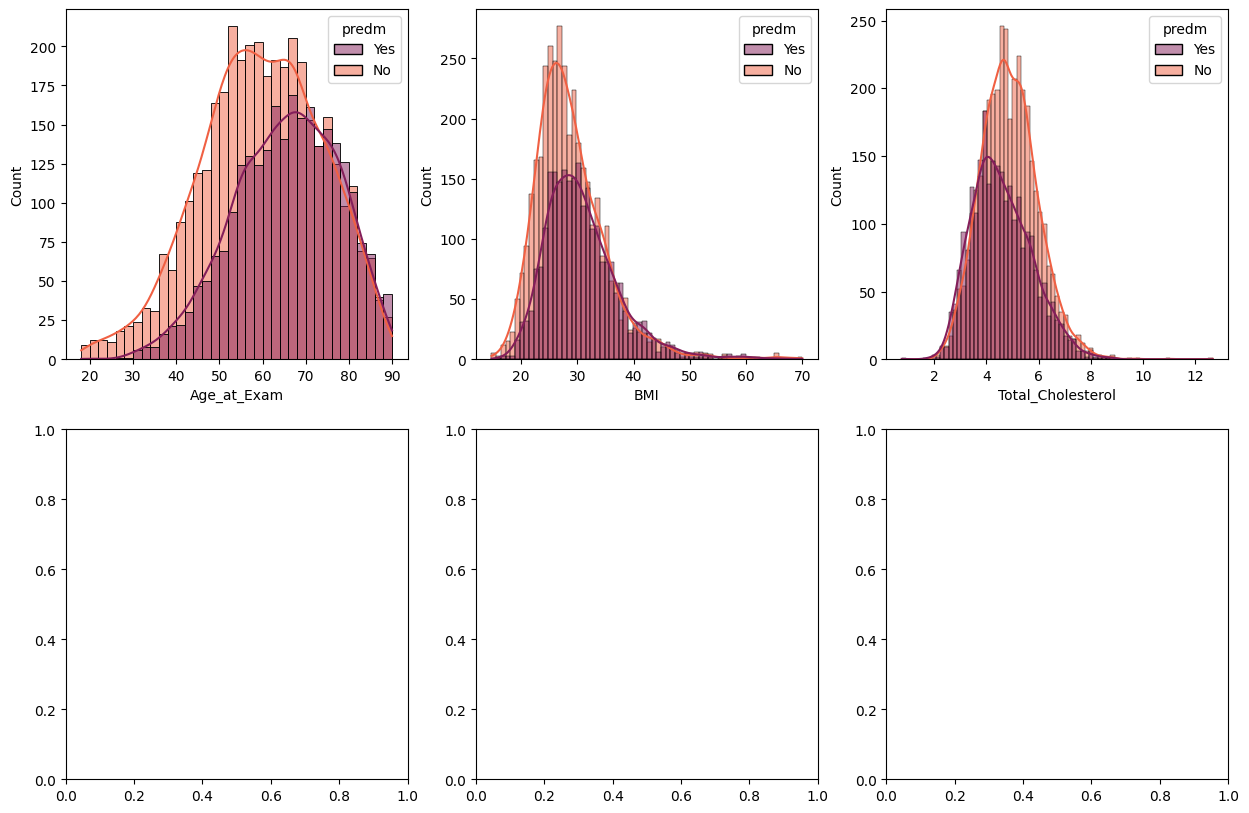

In [8]:
# checking the difference in distribution of numerical features in two classes

# Create a grid of subplots with 1 rows and 3 columns
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15, 10))

# Loop over each feature in numerical and multinomial lists
for i, column in enumerate(numerical_columns):
    # Calculate the position for the subplot; x is the row index and y is the column index
    x = i // 3
    y = i % 3

    # Plot a histogram of the feature split by the 'target' class
    # kde=True adds a Kernel Density Estimate plot to smooth the histogram, providing a clearer view of the data distribution
    sns.histplot(df_descr, x=column, hue= target_column, kde=True, palette='rocket', ax=axs[x][y])

# Display all the subplots
plt.show()


Proportion of positive cases

In [9]:
df['predm'].mean()

0.4078578110383536

Data Preparation

In [10]:
# Splitting the original dataset into training, validation, and test sets

# Taking 75% of the data for training
train_df = df.sample(frac = 0.75, random_state=42)

# Removing the training data from the original dataset to get the combined validation and test data
test_df = df.drop(train_df.index)

# Splitting the combined validation and test data into two equal parts for validation and testing, respectively
valid_df = test_df.sample(frac = 0.5, random_state=42)
test_df = test_df.drop(valid_df.index)

In [11]:
#Impute Missing Values
imputer = SimpleImputer(strategy='median')
train_df = pd.DataFrame(imputer.fit_transform(train_df), columns=train_df.columns)
test_df = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)
valid_df = pd.DataFrame(imputer.transform(valid_df), columns=valid_df.columns)

In [12]:
#double check if there are not missing values anymore
print(valid_df.isna().sum())
print(train_df.isna().sum())

Unnamed: 0           0
predm                0
Age_at_Exam          0
BMI                  0
Total_Cholesterol    0
Depression           0
HTN                  0
OA                   0
COPD                 0
corstrd_bin          0
htnmed_bin           0
Sex                  0
dtype: int64
Unnamed: 0           0
predm                0
Age_at_Exam          0
BMI                  0
Total_Cholesterol    0
Depression           0
HTN                  0
OA                   0
COPD                 0
corstrd_bin          0
htnmed_bin           0
Sex                  0
dtype: int64


In [13]:
# Data Preparation

# Extract the 'predm' column as the target variable for training and testing
Y_train = train_df['predm'].to_numpy()
Y_test = test_df['predm'].to_numpy()
Y_valid = valid_df['predm'].to_numpy()

# Extract the features (excluding 'predm') for training and testing
X_train = train_df.drop('predm', axis=1).to_numpy()
X_test = test_df.drop('predm', axis=1).to_numpy()
X_valid = valid_df.drop('predm', axis=1).to_numpy()

# Standardize the features to have zero mean and unit variance
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_valid = sc.transform(X_valid)

Initializing Neural Network Parameters in PyTorch

In [14]:
# Define the number of neurons in the first and second hidden layers
hidden_units_layer_1 = 10
hidden_units_layer_2 = 10

# FIRST LAYER: Define weights and biases for the first layer
W1 = t.randn((11, hidden_units_layer_1), requires_grad=True)
B1 = t.zeros((1, hidden_units_layer_1), requires_grad=True)

# SECOND LAYER: Define weights and biases for the second layer
W2 = t.randn((hidden_units_layer_1, hidden_units_layer_2), requires_grad=True)
B2 = t.zeros((1, hidden_units_layer_2), requires_grad=True)

# THIRD LAYER: Define weights and biases for the output layer
W3 = t.randn((hidden_units_layer_2, 1), requires_grad=True)
B3 = t.zeros((1, 1), requires_grad=True)

Implementing the Forward Pass of a Neural Network in PyTorch

In [15]:
# Define the forward pass of the neural network
def forward(input):
    # First hidden layer with tanh activation
    out = tanh(input @ W1 + B1)

    # Second hidden layer with tanh activation
    out = tanh(out @ W2 + B2)

    # Output layer with sigmoid activation (since it's a binary classification problem)
    out = sigmoid(out @ W3 + B3)
    return out

Preparing Data and Training Utilities for Neural Network Training in PyTorch

In [16]:
#Explicitly convert the data types of your NumPy array elements to a compatible numeric type
#X_train = X_train.astype(np.float32)
#Y_train = Y_train.astype(np.float32)

# Convert the training data to PyTorch tensors
X = t.Tensor(X_train).type(t.float32)
Y = t.Tensor(Y_train).type(t.float32)

# Create a dataset from tensors to be used with DataLoader
train_dataset = TensorDataset(X, Y)

# Define training hyperparameters
epochs = 2000
learning_rate = 0.001
batch_size = 25

# DataLoader provides batches of data for training
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the optimizer (Adam) and include all weights and biases
optimizer = Adam([W1, B1, W2, B2, W3, B3], lr=learning_rate)

# Define the loss function (Binary Cross-Entropy Loss)
loss_fn = t.nn.BCELoss()

Training Loop for a Neural Network in PyTorch

In [17]:
train_loss_list = [] #initializes an empty list to store the average loss of each epoch

# Train the model for a specified number of epochs
for epoch in range(epochs):
    # Reduce the learning rate every 500 epochs
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    # Iterate over all batches of data
    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = forward(X) #calls the forward function to compute predictions based on the batch of input data x

        # Compute the loss
        loss = loss_fn(probs.view(-1), Y)

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Record the loss for this batch
        per_epoch_loss_list.append(loss.item())

    # Record the average loss for this epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))

Visualizing Training Loss over Epochs with Maptlotlib in Python

Text(0, 0.5, 'Loss')

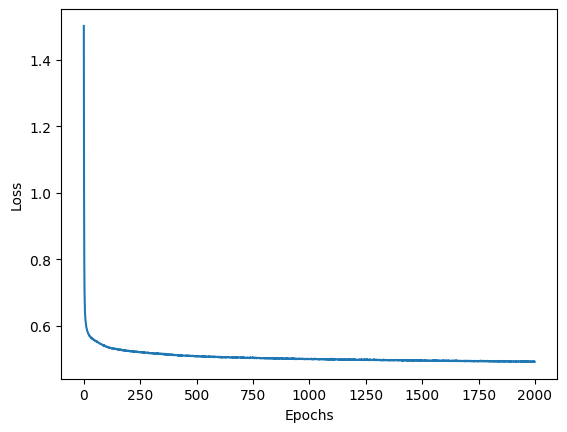

In [18]:
# Plot the training loss over epochs
plt.plot([i for i in range(len(train_loss_list))], train_loss_list)
plt.xlabel('Epochs')
plt.ylabel('Loss')

Evaluating Model Performance on Validation Data

In [19]:
# Evaluate Model Performance on Validation Data

# Disable gradient calculations for evaluation using t.no_grad()
with t.no_grad():
    # Prepare the validation data
    X_valid_tensor = t.Tensor(X_valid).type(t.float32)  # Convert validation features to a PyTorch tensor
    Y_valid_tensor = t.Tensor(Y_valid).type(t.float32)  # Convert validation labels to a PyTorch tensor

    # Calculate predictions on the validation data
    probs = forward(X_valid_tensor)  # Pass validation data through the trained model
    loss = loss_fn(probs.view(-1), Y_valid_tensor)  # Compute the loss between predictions and actual labels

    # Print the validation loss
    print(loss.item())

    # Now, evaluate the model on the training data
    X_train_tensor = t.Tensor(X_train).type(t.float32)  # Convert training features to a PyTorch tensor
    Y_train_tensor = t.Tensor(Y_train).type(t.float32)  # Convert training labels to a PyTorch tensor

    # Calculate predictions on the training data
    probs = forward(X_train_tensor)  # Pass training data through the trained model
    loss = loss_fn(probs.view(-1), Y_train_tensor)  # Compute the loss between predictions and actual labels

    # Print the training loss
    print(loss.item())

0.6770281195640564
0.488763689994812


Regularized Training of a Neural Network in Pytorch

In [20]:
import torch as t
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

# Regularization
# Deep neural networks are prone to overfitting if there is not much data available during training.

# Define hyperparameters
number_of_input_features = 11
number_of_hidden_units = 10
epochs = 200
learning_rate = 0.001
batch_size = 25
landa = 0.01  # Regularization term (lambda)

# Prepare the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_valid_tensor = t.Tensor(X_test).type(t.float32)
Y_valid_tensor = t.Tensor(Y_test).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model with regularization
model = nn.Sequential(
    nn.Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    nn.Tanh(),  # Tanh activation function
    nn.Linear(number_of_hidden_units, 1),  # Another linear layer
    nn.Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function with Binary Cross-Entropy Loss
loss_fn = nn.BCELoss()

# Lists to store training accuracy, validation accuracy, and training loss over epochs
train_accuracy_list = []
validation_accuracy_list = []
train_loss_list = []
train_recall_list = []
valid_recall_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Adding regularization term for all parameters in the model
        l2_term = sum([(w ** 2).sum() for w in model.parameters()])

        # New loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y) + landa * l2_term

        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradient and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        TP_train = t.sum((prediction == 1) & (Y_train_tensor == 1)).item()
        FN_train = t.sum((prediction == 0) & (Y_train_tensor == 1)).item()
        recall_train = TP_train / (TP_train + FN_train)

        # Calculate accuracy on validation data
        probs = model(X_valid_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        validation_accuracy = (prediction == Y_valid_tensor).type(t.float32).mean().item()

        TP_valid = t.sum((prediction == 1) & (Y_valid_tensor == 1)).item()
        FN_valid = t.sum((prediction == 0) & (Y_valid_tensor == 1)).item()
        recall_valid = TP_valid / (TP_valid + FN_valid)

        # Print accuracy for the current epoch
        print(f'Epoch {epoch}/{epochs} ---> Train Accuracy: {train_accuracy}, Validation Accuracy: {validation_accuracy}')
        print(f'epoch {epoch}/{epochs} ---> train_recall : {recall_train} , valid_recall : {recall_valid}')

        model.train()
        train_recall_list.append(recall_train)
        valid_recall_list.append(recall_valid)

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

    # Calculate and append the average loss for the epoch
    train_loss_list.append(sum(per_epoch_loss_list) / len(per_epoch_loss_list))


Epoch 0/200 ---> Train Accuracy: 0.7016631960868835, Validation Accuracy: 0.7044887542724609
epoch 0/200 ---> train_recall : 0.4812916453100974 , valid_recall : 0.5331325301204819
Epoch 1/200 ---> Train Accuracy: 0.7004157900810242, Validation Accuracy: 0.7007481455802917
epoch 1/200 ---> train_recall : 0.521783700666325 , valid_recall : 0.5662650602409639
Epoch 2/200 ---> Train Accuracy: 0.7010394930839539, Validation Accuracy: 0.6957606077194214
epoch 2/200 ---> train_recall : 0.5171706817016914 , valid_recall : 0.5692771084337349
Epoch 3/200 ---> Train Accuracy: 0.703326404094696, Validation Accuracy: 0.7044887542724609
epoch 3/200 ---> train_recall : 0.5140953357252691 , valid_recall : 0.5692771084337349
Epoch 4/200 ---> Train Accuracy: 0.704781711101532, Validation Accuracy: 0.7019950151443481
epoch 4/200 ---> train_recall : 0.5161455663762173 , valid_recall : 0.5662650602409639
Epoch 5/200 ---> Train Accuracy: 0.6997920870780945, Validation Accuracy: 0.6982543468475342
epoch 5/20

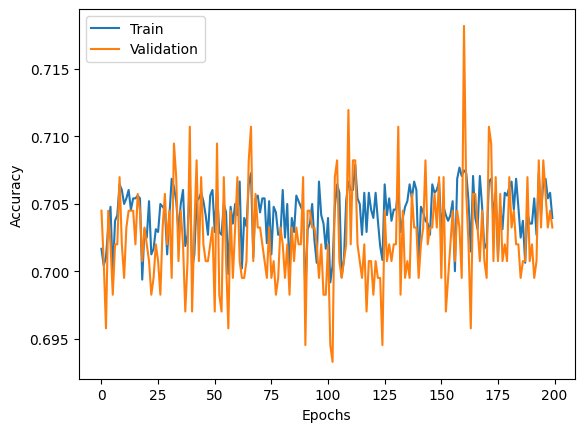

In [21]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="Train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

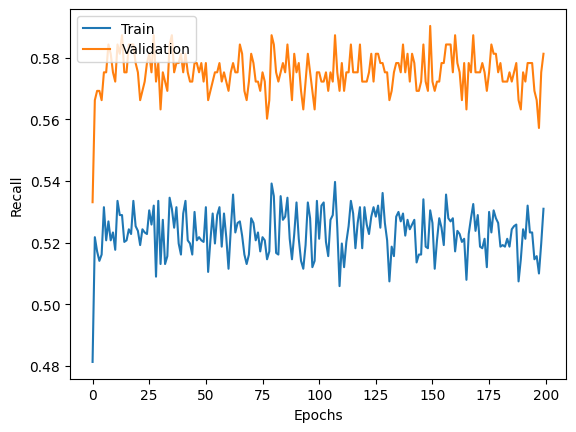

In [22]:
# Plot training and validation recall over epochs
plt.plot([i for i in range(len(train_recall_list))], train_recall_list, label="Train")
plt.plot([i for i in range(len(valid_recall_list))], valid_recall_list, label="Validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.show()

Neural Network with Dropout with Validation set

In [23]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score
number_of_input_features = 11  # Number of input features in the dataset

#from grid search:
#Hyperparameters: {'learning_rate': 0.001, 'batch_size': 25, 'number_of_hidden_units': 10, 'dropout_probability': 0.5}
#Validation Accuracy: 0.7331671118736267

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 10  # Number of hidden units in the neural network
epochs = 200  # Number of training epochs
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 25  # Number of samples in each training batch
dropout_probablity = 0.5  # Probability of dropping out a neuron in dropout layer

# Convert training and validation data to PyTorch tensors
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)
X_valid_tensor = t.Tensor(X_valid).type(t.float32)
Y_valid_tensor = t.Tensor(Y_valid).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    Tanh(),  # Add Tanh activation function
    Dropout(dropout_probablity),  # Dropout layer to prevent overfitting
    Linear(number_of_hidden_units, 1),  # Another linear layer
    Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = t.nn.BCELoss()

train_accuracy_list = []  # List to store training accuracy
valid_accuracy_list = []  # List to store validation accuracy
train_recall_list = []
valid_recall_list = []

for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        TP_train = t.sum((prediction == 1) & (Y_train_tensor == 1)).item()
        FN_train = t.sum((prediction == 0) & (Y_train_tensor == 1)).item()
        recall_train = TP_train / (TP_train + FN_train)

        # Calculate accuracy on validation data
        probs = model(X_valid_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        valid_accuracy = (prediction == Y_valid_tensor).type(t.float32).mean().item()

        TP_valid = t.sum((prediction == 1) & (Y_valid_tensor == 1)).item()
        FN_valid = t.sum((prediction == 0) & (Y_valid_tensor == 1)).item()
        recall_valid = TP_valid / (TP_valid + FN_valid)

        conf_matrix_test = confusion_matrix(Y_valid_tensor, prediction)
        TN_valid = conf_matrix_test[0, 0]
        FP_valid = conf_matrix_test[0, 1]
        TP_valid = conf_matrix_test[1, 1]
        FN_valid = conf_matrix_test[1, 0]

        # Calculate AUC
        auc_valid = roc_auc_score(Y_valid_tensor.numpy(), probs.numpy())

        # Calculate precision
        precision_valid = precision_score(Y_valid_tensor.numpy(), prediction.numpy())

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, valid_accuracy: {valid_accuracy}')
        print(f'epoch {epoch}/{epochs} ---> train_recall : {recall_train} , valid_recall : {recall_valid}')
        print(f'epoch {epoch}/{epochs} ---> TN_valid: {TN_valid}, FP_valid: {FP_valid}, TP_valid: {TP_valid}, FN_valid: {FN_valid}')
        print(f'epoch {epoch}/{epochs} ---> AUC_valid: {auc_valid}')
        print(f'epoch {epoch}/{epochs} ---> Precision_valid: {precision_valid}')

        model.train()
        train_recall_list.append(recall_train)
        valid_recall_list.append(recall_valid)

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        valid_accuracy_list.append(valid_accuracy)

epoch 0/200 ---> train_accuracy: 0.6864864826202393, valid_accuracy: 0.6670823097229004
epoch 0/200 ---> train_recall : 0.41619682214249104 , valid_recall : 0.40540540540540543
epoch 0/200 ---> TN_valid: 400, FP_valid: 69, TP_valid: 135, FN_valid: 198
epoch 0/200 ---> AUC_valid: 0.7042842415976744
epoch 0/200 ---> Precision_valid: 0.6617647058823529
epoch 1/200 ---> train_accuracy: 0.6975051760673523, valid_accuracy: 0.6645885109901428
epoch 1/200 ---> train_recall : 0.504356740133265 , valid_recall : 0.4924924924924925
epoch 1/200 ---> TN_valid: 369, FP_valid: 100, TP_valid: 164, FN_valid: 169
epoch 1/200 ---> AUC_valid: 0.7101877997400386
epoch 1/200 ---> Precision_valid: 0.6212121212121212
epoch 2/200 ---> train_accuracy: 0.7008315920829773, valid_accuracy: 0.6683291792869568
epoch 2/200 ---> train_recall : 0.5140953357252691 , valid_recall : 0.4924924924924925
epoch 2/200 ---> TN_valid: 372, FP_valid: 97, TP_valid: 164, FN_valid: 169
epoch 2/200 ---> AUC_valid: 0.7147211177061924
e

Text(0, 0.5, 'accuracy')

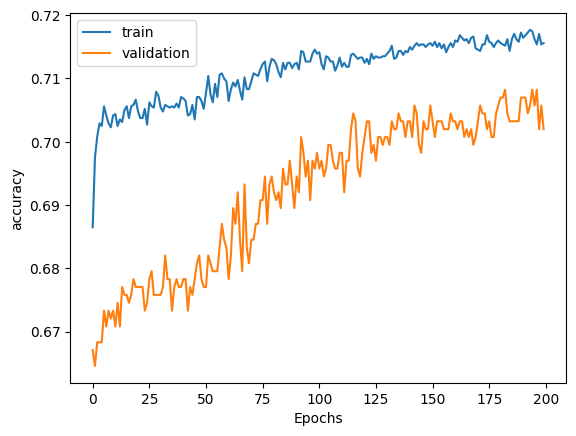

In [24]:
# Plot training and validation accuracy over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(valid_accuracy_list))], valid_accuracy_list, label="validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('accuracy')

Text(0, 0.5, 'recall')

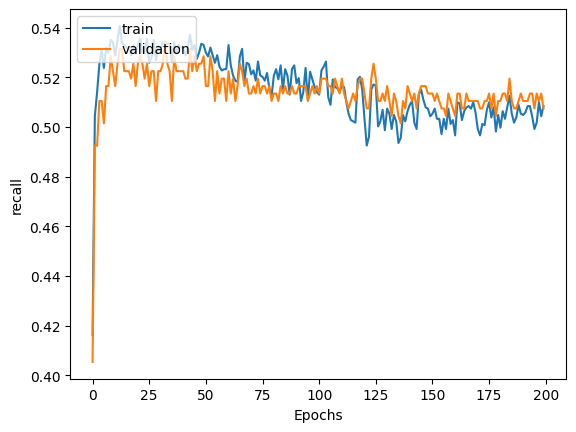

In [25]:
# Plot training and validation recall over epochs
plt.plot([i for i in range(len(train_accuracy_list))], train_recall_list, label="train")
plt.plot([i for i in range(len(valid_recall_list))], valid_recall_list, label="validation")
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('recall')

Neural Network with Early Stopping

In [26]:
# Importing necessary libraries
import torch as t
from torch.utils.data import TensorDataset, DataLoader
from torch.nn import Sequential, Linear, Tanh, Sigmoid
from torch.optim import Adam
from torch.nn import BCELoss
import matplotlib.pyplot as plt

# Defining the parameters
number_of_input_features = 11
number_of_hidden_units = 10
epochs = 200
learning_rate = 0.001
batch_size = 25

# Loading and preprocessing the data
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)

X_valid_tensor = t.Tensor(X_valid).type(t.float32)
Y_valid_tensor = t.Tensor(Y_valid).type(t.float32)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Creating a neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),
    Tanh(),
    Linear(number_of_hidden_units, 1),
    Sigmoid()
)

# Setting up the optimizer and loss function
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = BCELoss()

# Lists to store accuracy values during training
train_accuracy_list = []
valid_accuracy_list = []
train_recall_list = []
valid_recall_list = []

# Main training loop
for epoch in range(epochs):
    # Learning rate scheduling (optional)
    if epoch % 500 == 0:
        learning_rate *= .9

    per_epoch_loss_list = []

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        probs = model(X)

        # new loss is the old loss + regularization term
        loss = loss_fn(probs.view(-1), Y)

        per_epoch_loss_list.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    with t.no_grad():
        # Calculate accuracy on train data
        model.eval()
        probs = model(X_train_tensor)
        prediction = (probs >= .5).type(t.LongTensor).view(-1)

        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        TP_train = t.sum((prediction == 1) & (Y_train_tensor == 1)).item()
        FN_train = t.sum((prediction == 0) & (Y_train_tensor == 1)).item()
        recall_train = TP_train / (TP_train + FN_train)

        # Calculate accuracy on validation data
        probs = model(X_valid_tensor)
        prediction = (probs > .5).type(t.LongTensor).view(-1)

        validation_accuracy = (prediction == Y_valid_tensor).type(t.float32).mean().item()

        print(f'epoch {epoch}/{epochs} ---> train_accuracy : {train_accuracy} , validation_accuracy : {validation_accuracy}')
        model.train()
        train_accuracy_list.append(train_accuracy)
        validation_accuracy_list.append(validation_accuracy)

        TP_valid = t.sum((prediction == 1) & (Y_valid_tensor == 1)).item()
        FN_valid = t.sum((prediction == 0) & (Y_valid_tensor == 1)).item()
        recall_valid = TP_valid / (TP_valid + FN_valid)

        print(f'epoch {epoch}/{epochs} ---> train_recall : {recall_train} , validation_recall : {recall_valid}')
        model.train()
        train_recall_list.append(recall_train)
        valid_recall_list.append(recall_valid)

epoch 0/200 ---> train_accuracy : 0.6632016897201538 , validation_accuracy : 0.6396508812904358
epoch 0/200 ---> train_recall : 0.6340338288057407 , validation_recall : 0.6306306306306306
epoch 1/200 ---> train_accuracy : 0.6945946216583252 , validation_accuracy : 0.6733167171478271
epoch 1/200 ---> train_recall : 0.5299846232701179 , validation_recall : 0.5255255255255256
epoch 2/200 ---> train_accuracy : 0.7043659090995789 , validation_accuracy : 0.6832917928695679
epoch 2/200 ---> train_recall : 0.5202460276781138 , validation_recall : 0.5075075075075075
epoch 3/200 ---> train_accuracy : 0.7031185030937195 , validation_accuracy : 0.6820448637008667
epoch 3/200 ---> train_recall : 0.5274218349564326 , validation_recall : 0.5255255255255256
epoch 4/200 ---> train_accuracy : 0.704781711101532 , validation_accuracy : 0.6832917928695679
epoch 4/200 ---> train_recall : 0.5197334700153767 , validation_recall : 0.5105105105105106
epoch 5/200 ---> train_accuracy : 0.7068607211112976 , valida

Text(0, 0.5, 'Accuracy')

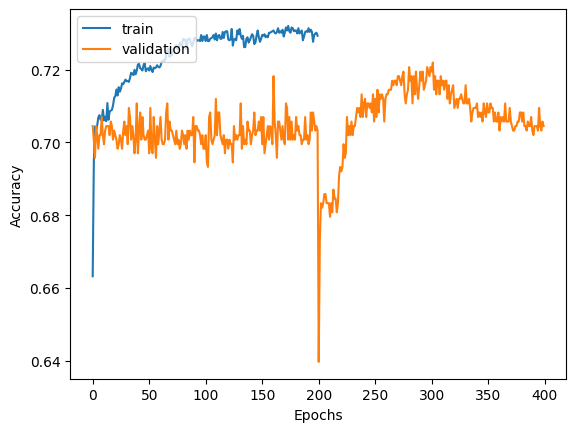

In [27]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(validation_accuracy_list))], validation_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Recall')

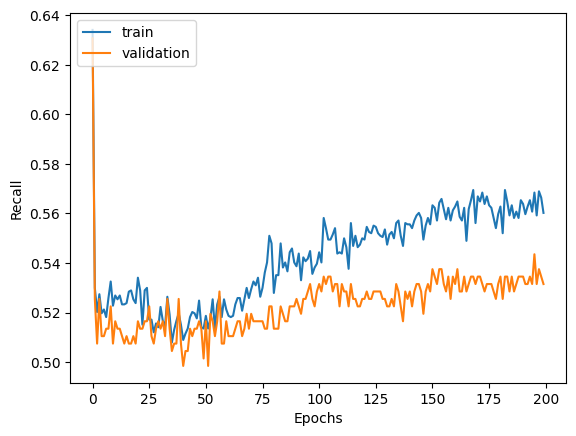

In [28]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_recall_list))], train_recall_list, label="train")
plt.plot([i for i in range(len(valid_recall_list))], valid_recall_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Recall')

Final Neural Network Test Set Performance

In [37]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score
from torch.nn import BCELoss

number_of_input_features = 11  # Number of input features in the dataset

#Hyperparameters: {'learning_rate': 0.001, 'batch_size': 25, 'number_of_hidden_units': 10, 'dropout_probability': 0.5}
#Validation Accuracy: 0.7331671118736267

# Reduced number of hidden units to 5 and just using 1 hidden layer
number_of_hidden_units = 10  # Number of hidden units in the neural network
epochs = 500  # Number of training epochs
learning_rate = 0.001  # Learning rate for the optimizer
batch_size = 25  # Number of samples in each training batch

# Convert training and testing data to PyTorch tensors
X_train_tensor = t.Tensor(X_train).type(t.float32)
Y_train_tensor = t.Tensor(Y_train).type(t.float32)
X_test_tensor = t.Tensor(X_test).type(t.float32)
Y_test_tensor = t.Tensor(Y_test).type(t.float32)

# Create a training dataset and data loader
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Define the neural network model
model = Sequential(
    Linear(number_of_input_features, number_of_hidden_units),  # Linear layer for matrix multiplication and bias addition
    Tanh(),  # Add Tanh activation function
    Linear(number_of_hidden_units, 1),  # Another linear layer
    Sigmoid()  # Sigmoid activation for probability output
)

# Define the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)

# Define the loss function as Binary Cross-Entropy Loss
loss_fn = BCELoss()

train_accuracy_list = []  # List to store training accuracy
test_accuracy_list = []  # List to store validation accuracy
train_recall_list = []
test_recall_list = []

#Main training loop
for epoch in range(epochs):
    if epoch % 500 == 0:
        learning_rate *= 0.9  # Learning rate scheduling

    per_epoch_loss_list = []  # List to store losses for each epoch

    for batch_idx, (X, Y) in enumerate(train_data_loader):
        # Forward pass: Compute predictions
        probs = model(X)

        # Calculate the loss
        loss = loss_fn(probs.view(-1), Y)
        per_epoch_loss_list.append(loss.item())

        # Backward pass: Compute gradients and update weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluate the model on training and validation data
    with t.no_grad():
        # Set the model in eval mode; some layers use this for certain calculations during training
        model.eval()

        # Calculate accuracy on train data
        probs = model(X_train_tensor)
        prediction = (probs >= 0.5).type(t.LongTensor).view(-1)
        train_accuracy = (prediction == Y_train_tensor).type(t.float32).mean().item()

        TP_train = t.sum((prediction == 1) & (Y_train_tensor == 1)).item()
        FN_train = t.sum((prediction == 0) & (Y_train_tensor == 1)).item()
        recall_train = TP_train / (TP_train + FN_train)

        # Calculate accuracy on test data
        probs = model(X_test_tensor)
        prediction = (probs > 0.5).type(t.LongTensor).view(-1)
        test_accuracy = (prediction == Y_test_tensor).type(t.float32).mean().item()

        TP_test = t.sum((prediction == 1) & (Y_test_tensor == 1)).item()
        FN_test = t.sum((prediction == 0) & (Y_test_tensor == 1)).item()
        recall_test = TP_test / (TP_test + FN_test)

        conf_matrix_test = confusion_matrix(Y_test_tensor, prediction)
        TN_test = conf_matrix_test[0, 0]
        FP_test = conf_matrix_test[0, 1]
        TP_test = conf_matrix_test[1, 1]
        FN_test = conf_matrix_test[1, 0]

        # Calculate AUC
        auc_test = roc_auc_score(Y_test_tensor.numpy(), probs.numpy())

        # Calculate precision
        precision_test = precision_score(Y_test_tensor.numpy(), prediction.numpy())

        print(f'epoch {epoch}/{epochs} ---> train_accuracy: {train_accuracy}, test_accuracy: {test_accuracy}')
        print(f'epoch {epoch}/{epochs} ---> train_recall : {recall_train} , test_recall : {recall_test}')
        print(f'epoch {epoch}/{epochs} ---> TN_test: {TN_test}, FP_test: {FP_test}, TP_test: {TP_test}, FN_test: {FN_test}')
        print(f'epoch {epoch}/{epochs} ---> AUC_test: {auc_test}')
        print(f'epoch {epoch}/{epochs} ---> Precision_test: {precision_test}')

        model.train()
        train_recall_list.append(recall_train)
        test_recall_list.append(recall_test)

        # Set the model back to train mode
        model.train()

        # Append accuracy values to lists
        train_accuracy_list.append(train_accuracy)
        test_accuracy_list.append(test_accuracy)

epoch 0/500 ---> train_accuracy: 0.6686070561408997, test_accuracy: 0.6446384191513062
epoch 0/500 ---> train_recall : 0.5079446437724244 , test_recall : 0.5180722891566265
epoch 0/500 ---> TN_test: 345, FP_test: 125, TP_test: 172, FN_test: 160
epoch 0/500 ---> AUC_test: 0.7028390156370162
epoch 0/500 ---> Precision_test: 0.5791245791245792
epoch 1/500 ---> train_accuracy: 0.6891891956329346, test_accuracy: 0.6832917928695679
epoch 1/500 ---> train_recall : 0.5089697590978985 , test_recall : 0.5421686746987951
epoch 1/500 ---> TN_test: 368, FP_test: 102, TP_test: 180, FN_test: 152
epoch 1/500 ---> AUC_test: 0.7317354524480904
epoch 1/500 ---> Precision_test: 0.6382978723404256
epoch 2/500 ---> train_accuracy: 0.6995841860771179, test_accuracy: 0.7057356834411621
epoch 2/500 ---> train_recall : 0.5140953357252691 , test_recall : 0.5692771084337349
epoch 2/500 ---> TN_test: 377, FP_test: 93, TP_test: 189, FN_test: 143
epoch 2/500 ---> AUC_test: 0.7402396821327866
epoch 2/500 ---> Precisi

Text(0, 0.5, 'Recall')

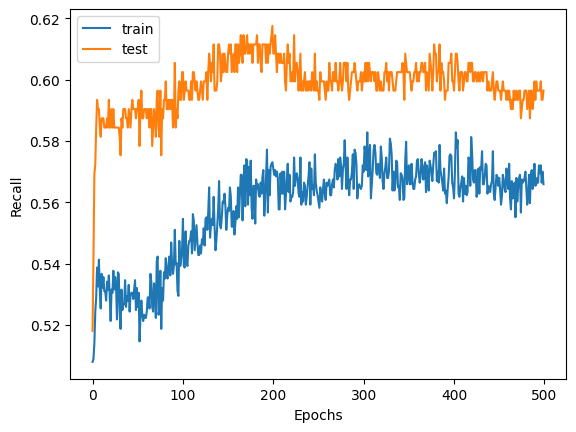

In [38]:
# Plotting the training and validation recall
plt.plot([i for i in range(len(train_recall_list))], train_recall_list, label="train")
plt.plot([i for i in range(len(test_recall_list))], test_recall_list, label='test')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Recall')

Text(0, 0.5, 'Accuracy')

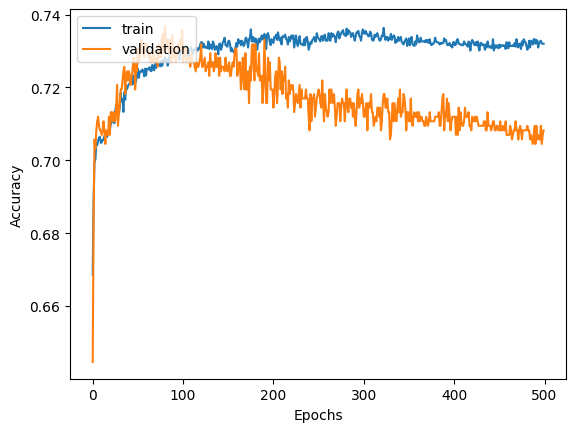

In [40]:
# Plotting the training and validation accuracy
plt.plot([i for i in range(len(train_accuracy_list))], train_accuracy_list, label="train")
plt.plot([i for i in range(len(test_accuracy_list))], test_accuracy_list, label='validation')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')